# Implementing the Kuramoto model and storing phases
##### ref: https://github.com/fabridamicelli/kuramoto
##### --version_1
##### Farverdin 1404

### Import libraries and kuramoto class

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from tqdm import tqdm

class Kuramoto:

    def __init__(self, coupling=1, dt=0.01, T=10, n_nodes=None, natfreqs=None):
        '''
        coupling: float
            Coupling strength. Default = 1. Typical values range between 0.4-2
        dt: float
            Delta t for integration of equations.
        T: float
            Total time of simulated activity.
            From that the number of integration steps is T/dt.
        n_nodes: int, optional
            Number of oscillators.
            If None, it is inferred from len of natfreqs.
            Must be specified if natfreqs is not given.
        natfreqs: 1D ndarray, optional
            Natural oscillation frequencies.
            If None, then new random values will be generated and kept fixed
            for the object instance.
            Must be specified if n_nodes is not given.
            If given, it overrides the n_nodes argument.
        '''
        if n_nodes is None and natfreqs is None:
            raise ValueError("n_nodes or natfreqs must be specified")

        self.dt = dt
        self.T = T
        self.coupling = coupling

        if natfreqs is not None:
            self.natfreqs = natfreqs
            self.n_nodes = len(natfreqs)
        else:
            self.n_nodes = n_nodes
            self.natfreqs = np.random.normal(size=self.n_nodes)

    def init_angles(self):
        '''
        Random initial random angles (position, "theta").
        '''
        return 2 * np.pi * np.random.random(size=self.n_nodes)

    def derivative(self, angles_vec, t, adj_mat, coupling):
        '''
        Compute derivative of all nodes for current state, defined as

        dx_i    natfreq_i + k  sum_j ( Aij* sin (angle_j - angle_i) )
        ---- =             ---
         dt                M_i

        t: for compatibility with scipy.odeint
        '''
        assert len(angles_vec) == len(self.natfreqs) == len(adj_mat), \
            'Input dimensions do not match, check lengths'

        angles_i, angles_j = np.meshgrid(angles_vec, angles_vec)
        interactions = adj_mat * np.sin(angles_j - angles_i)  # Aij * sin(j-i)

        dxdt = self.natfreqs + coupling * interactions.sum(axis=0)  # sum over incoming interactions
        return dxdt

    def integrate(self, angles_vec, adj_mat):
        '''Updates all states by integrating state of all nodes'''
        # Coupling term (k / Mj) is constant in the integrated time window.
        # Compute it only once here and pass it to the derivative function
        n_interactions = (adj_mat != 0).sum(axis=0)  # number of incoming interactions
        coupling = self.coupling / n_interactions  # normalize coupling by number of interactions

        t = np.linspace(0, self.T, int(self.T/self.dt))
        timeseries = odeint(self.derivative, angles_vec, t, args=(adj_mat, coupling))
        return timeseries.T  # transpose for consistency (act_mat:node vs time)

    def run(self, adj_mat=None, angles_vec=None):
        '''
        adj_mat: 2D nd array
            Adjacency matrix representing connectivity.
        angles_vec: 1D ndarray, optional
            States vector of nodes representing the position in radians.
            If not specified, random initialization [0, 2pi].

        Returns
        -------
        act_mat: 2D ndarray
            Activity matrix: node vs time matrix with the time series of all
            the nodes.
        '''
        if angles_vec is None:
            angles_vec = self.init_angles()

        return self.integrate(angles_vec, adj_mat)

    @staticmethod
    def phase_coherence(angles_vec):
        '''
        Compute global order parameter R_t - mean length of resultant vector
        '''
        suma = sum([(np.e ** (1j * i)) for i in angles_vec])
        return abs(suma / len(angles_vec))

    def mean_frequency(self, act_mat, adj_mat):
        '''
        Compute average frequency within the time window (self.T) for all nodes
        '''
        assert len(adj_mat) == act_mat.shape[0], 'adj_mat does not match act_mat'
        _, n_steps = act_mat.shape

        # Compute derivative for all nodes for all time steps
        dxdt = np.zeros_like(act_mat)
        for time in range(n_steps):
            dxdt[:, time] = self.derivative(act_mat[:, time], None, adj_mat)

        # Integrate all nodes over the time window T
        integral = np.sum(dxdt * self.dt, axis=1)
        # Average across complete time window - mean angular velocity (freq.)
        meanfreq = integral / self.T
        return meanfreq

### Plot functions

In [3]:
# plot def
def plot_activity(activity, save_path=None):
    """
    Plot sin(angle) vs time for each oscillator time series.

    activity: 2D-np.ndarray
        Activity time series, node vs. time; ie output of Kuramoto.run()
    return:
        matplotlib axis for further customization
    """
    _, ax = plt.subplots(figsize=(12, 4))
    ax.plot(np.sin(activity.T))
    ax.set_xlabel('Time', fontsize=25)
    ax.set_ylabel(r'$\sin(\theta)$', fontsize=25)
    if save_path:
        ax.figure.savefig(save_path, dpi=300, bbox_inches='tight')
    return ax

def plot_phase_coherence(activity, save_path=None):
    """
    Plot order parameter phase_coherence vs time.

    activity: 2D-np.ndarray
        Activity time series, node vs. time; i.e., output of Kuramoto.run()
    save_path: str or None
        If provided, the figure will be saved to this path.
    
    return:
        matplotlib axis for further customization
    """
    _, ax = plt.subplots(figsize=(8, 3))
    ax.plot([Kuramoto.phase_coherence(vec) for vec in activity.T])
    ax.set_ylabel('Order parameter', fontsize=20)
    ax.set_xlabel('Time', fontsize=20)
    ax.set_ylim((-0.01, 1))
    if save_path:
        ax.figure.savefig(save_path, dpi=300, bbox_inches='tight')  # Save if path is given 
    return ax


### Try a basic model

In [4]:
graph_nx = nx.erdos_renyi_graph(n=100, p=1) # p=1 -> all-to-all connectivity
graph = nx.to_numpy_array(graph_nx)
print(graph)

[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


In [5]:
# create a special init angel in txt file
#arr = 2 * np.pi * np.random.random(size=100)
#np.savetxt('init_angles.txt', arr, fmt='%.4f')

# create a special natural freq in txt file
#arr2 = np.random.normal(size=100)
#np.savetxt('natural_freq.txt', arr2, fmt='%.4f')

In [6]:
model = Kuramoto(coupling=3, dt=0.1, T=500, n_nodes=len(graph),natfreqs=np.loadtxt('natural_freq.txt'))                 
act_mat = model.run(adj_mat=graph,angles_vec=np.loadtxt('init_angles.txt'))
print(act_mat.shape)

(100, 5000)


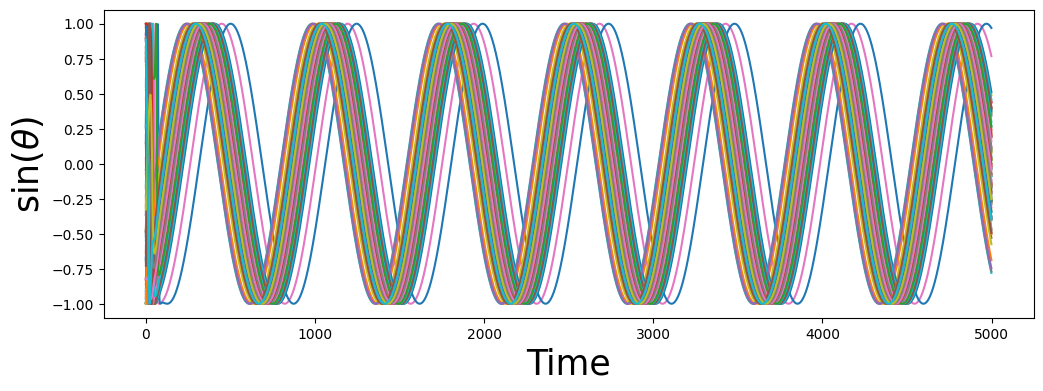

In [7]:
plot_activity(act_mat, save_path="sin_theta_vs_time.png");

<Axes: xlabel='Time', ylabel='Order parameter'>

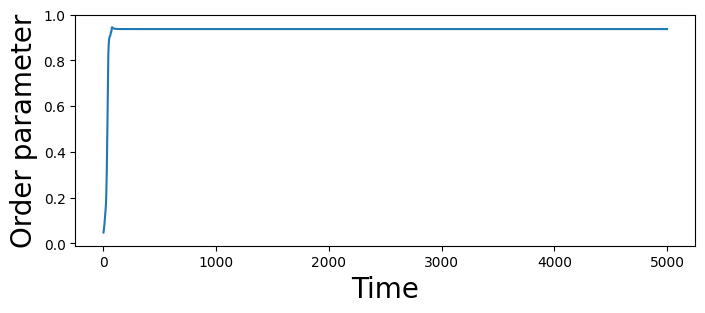

In [8]:
plot_phase_coherence(act_mat, save_path="order_parameter_vs_time_a_coupling_value.png")

### Kuramoto phase transition with different coupling values and save phases

In [9]:
# Instantiate a random graph and transform into an adjacency matrix
n_nodes = 100                                                           # Number of oscillators (nodes in the network)
min_coupling_J=0                                                        # Minimum coupling strength (scaled)
max_coupling_J=2.2                                                      # Maximum coupling strength (scaled)
num_coupling=220                                                        # Number of coupling strength values to test
final_time=40                                                            # Total simulation time
step_time=0.1                                                           # Time step for simulation
total_time=int(final_time/step_time)                                    # Total number of time steps
sync_memory_time=int((final_time/step_time)*0.8)                        # Time point to consider for measuring synchronization
Kc = np.sqrt(8 / np.pi) * np.std(model.natfreqs)                        # Critical coupling strength (analytical formula using std of natural frequencies)
min_coupling=Kc*min_coupling_J                                          # Rescaled minimum coupling strength
max_coupling=Kc*max_coupling_J                                          # Rescaled maximum coupling strength

graph_nx = nx.erdos_renyi_graph(n=n_nodes, p=1)                         # Create an Erdos-Renyi graph with full connectivity (p=1)
adj_matrix = nx.to_numpy_array(graph_nx)                                # Convert graph to adjacency matrix

# init_angles and natural_freq
init_angles=2 * np.pi * np.random.random(size=n_nodes)                  # Initial phases for all oscillators (uniformly sampled between 0 and 2π)
natural_freq = np.random.normal(0, 1, size=n_nodes)                     # Natural frequencies for each oscillator (Gaussian distribution)

# Run model with different coupling (K) parameters
coupling_vals = np.linspace(min_coupling, max_coupling, num_coupling)   # Coupling values from min to max
runs = []                                                               # List to store activity matrices from each run
for coupling in tqdm(coupling_vals):                                    # Loop over all coupling strengths
    model = Kuramoto(coupling=coupling, dt=step_time, T=final_time, 
                     n_nodes=len(adj_matrix), natfreqs=natural_freq)    # Instantiate Kuramoto model with given parameters
    act_mat = model.run(adj_mat=adj_matrix, angles_vec=init_angles)     # Run the model and get phase matrix
    runs.append(act_mat)                                                # Store the result
    init_angles=act_mat[:,-1]                                           # Use final state as initial for next run

runs_array = np.array(runs);                                            # Convert list of runs into a NumPy array

# Check that natural frequencies are correct (we need them for prediction of Kc)
#plt.figure()
#plt.hist(model.natfreqs)                                               # Plot histogram of natural frequencies (commented out)
#plt.xlabel('natural frequency')       
#plt.ylabel('count')                   

  0%|          | 0/220 [00:00<?, ?it/s]

100%|██████████| 220/220 [01:09<00:00,  3.14it/s]


#### Save phases

In [10]:
print('3d array (J,n_nodes,time): ', runs_array.shape)          # Shape: (num_coupling, n_nodes, total_time)

arr_time = []                                                   # List to store flattened (coupling, time) phase data across all nodes
for coup in range(num_coupling):                                # Loop over each coupling value
    for time in range(total_time):                              # Loop over each time step
        arr_angles = []                                         # List to collect phases for all nodes at this (coup, time)
        for angle in range(n_nodes):                            # Loop over each node
            arr_angles.append(runs_array[coup, angle, time])    # Correct: use the current coupling index (not fixed at 0)
        arr_time.append(arr_angles)                             # Append this snapshot to the 2D list

runs_array_2d = np.array(arr_time)                              # Convert to a 2D NumPy array of shape (num_coupling * total_time, n_nodes)
print('2d array (J*time,n_nodes): ', runs_array_2d.shape)       # Should be (num_coupling × total_time, n_nodes)

np.savez_compressed('./Angles.npz', phases=runs_array_2d)       # Save the processed 2D array

# To load later:
# data = np.load('./Angles.npz')
# runs_array_2d = data['phases']


3d array (J,n_nodes,time):  (220, 100, 400)
2d array (J*time,n_nodes):  (88000, 100)


#### Plot R(t)

0it [00:00, ?it/s]

220it [00:05, 39.93it/s]


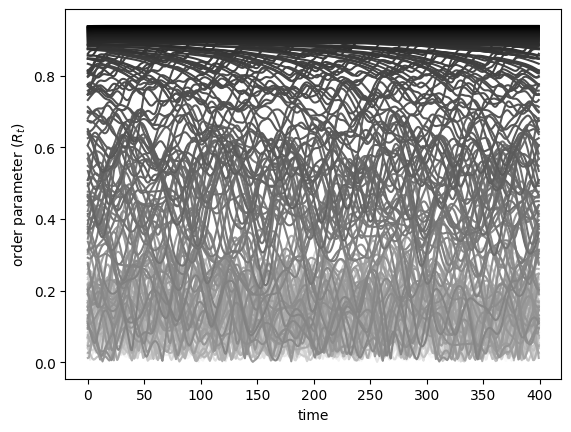

In [11]:
# Plot all time series for all coupling values (color coded)
plt.figure()                                                # Create a new figure for the plot

for i, coupling in tqdm(enumerate(coupling_vals)):          # Loop over each coupling value (with index)
    plt.plot(
        [model.phase_coherence(vec)                         # Compute order parameter R(t) at each time step
         for vec in runs_array[i, ::].T],                   # Transpose to loop over time (shape: time x n_nodes)
        c=str((max_coupling - coupling) / max_coupling)     # Map coupling to grayscale: higher coupling = darker line
    )

plt.ylabel(r'order parameter ($R_t$)')                      # Y-axis label: R(t), the phase coherence
plt.xlabel('time')                                          # X-axis label: time steps
plt.savefig('R(t)_all_couplings.png', dpi=300, bbox_inches='tight')  # Save the plot

#### Plot phase transition

0it [00:00, ?it/s]

220it [00:04, 54.77it/s]


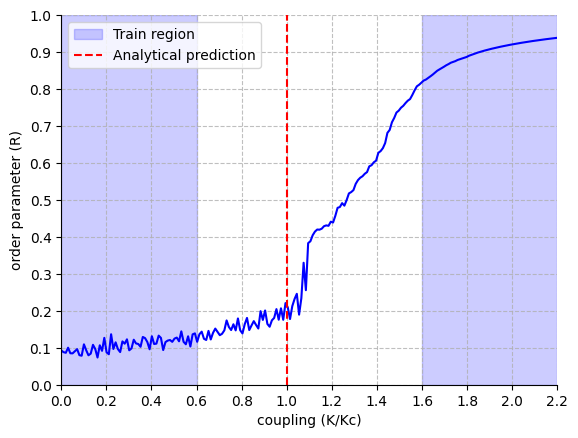

In [12]:
# Plot final Rt for each coupling value
arr_coupling = []                                                       # List to store coupling values normalized by Kc
arr_R = []                                                              # List to store corresponding mean order parameter (R) values

for i, coupling in tqdm(enumerate(coupling_vals)):                      # Loop over each coupling value and its index
    r_mean = np.mean([model.phase_coherence(vec)                        # Calculate the mean phase coherence over the last 1000 time steps
                      for vec in runs_array[i, :, -sync_memory_time:].T])  # Mean over the last 'sync_memory_time' steps
    #plt.scatter(coupling, r_mean, c='steelblue', s=20, alpha=0.7)      # (Commented out) Plot scatter for each coupling vs R
    arr_coupling.append(coupling/Kc)                                    # Append normalized coupling value to the list
    arr_R.append(r_mean)                                                # Append the computed mean R value to the list

plt.figure()                                                            # Create a new figure for plotting
plt.plot(arr_coupling, arr_R, c='b')                                    # Plot the coupling vs order parameter (R) with a blue line
plt.axvspan(0, 0.6, color='blue', alpha=0.2)                            # Highlight the region 0 < K/Kc < 0.6 with a semi-transparent blue shade
plt.axvspan(1.6, 2.2, color='blue', alpha=0.2, label='Train region')    # Highlight the training region (1.6 < K/Kc < 2.2)
plt.vlines(Kc/Kc, 0, 1, linestyles='--', color='r', label='Analytical prediction')  # Vertical line at Kc/Kc to mark the analytical prediction
plt.legend(loc='upper left')                                            # Show the legend in the upper left corner
plt.grid(linestyle='--', alpha=0.8)                                     # Add a grid with dashed lines and 80% transparency
plt.ylabel('order parameter (R)')                                       
plt.xlabel('coupling (K/Kc)')     
plt.xlim(0, 2.2)                                                        # Set x-axis limits from 0 to 2.2
plt.xticks(np.arange(0, 2.4, 0.2))                                      # Set x-axis ticks at intervals of 0.2
plt.ylim(0, 1)                                                          # Set y-axis limits from 0 to 1
plt.yticks(np.arange(0, 1.1, 0.1))                                      # Set y-axis ticks at intervals of 0.1
sns.despine()                                                           # Remove the top and right spines for a cleaner look
plt.savefig('order_parameter_vs_coupling.png', dpi=300, bbox_inches='tight')